In [20]:
from tkinter import N
from joblib import PrintTime
import pvlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import daytime
import Funciones  
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

In [21]:
#Definir Zona Horaria
tz = 'America/Bogota'
lat, lon = 9.789103, -73.722451 #Estas son las coordenas
altitude=50

In [22]:
location = pvlib.location.Location(lat, lon, tz, altitude)

api_key = 'rMYPYAhkiXjb9WUAjQVU728EI59XhF2TeY9ml5cz'
email = 'da.parral@uniandes.edu.co'
elpaso_tmy, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                            names='2020', interval=30)

In [23]:
tmy_columns_rename = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'temp_air', 'Dew Point', 'dhi', 'dni', 'ghi', 'albedo', 'Pressure', 'Wind Direction', 'wind_speed']
elpaso_tmy.columns = tmy_columns_rename
elpaso_tmy.head()

,Year,Month,Day,Hour,Minute,temp_air,Dew Point,dhi,dni,ghi,albedo,Pressure,Wind Direction,wind_speed
2020-01-01 00:00:00-05:00,2020,1,1,0,0,26.2,22.3,0.0,0.0,0.0,0.18,998.0,64.0,0.1
2020-01-01 00:30:00-05:00,2020,1,1,0,30,26.0,22.3,0.0,0.0,0.0,0.18,998.0,64.0,0.1
2020-01-01 01:00:00-05:00,2020,1,1,1,0,25.7,22.1,0.0,0.0,0.0,0.18,997.0,65.0,0.0
2020-01-01 01:30:00-05:00,2020,1,1,1,30,25.6,22.1,0.0,0.0,0.0,0.18,997.0,106.0,0.0
2020-01-01 02:00:00-05:00,2020,1,1,2,0,25.5,21.5,0.0,0.0,0.0,0.18,997.0,147.0,0.0


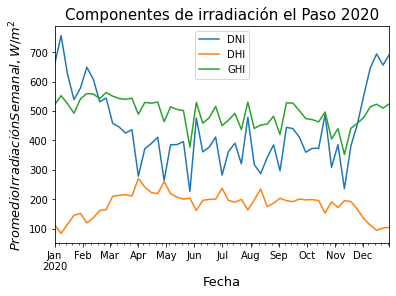

In [66]:
elpaso_tmy.dni.resample("7D").mean().plot()
elpaso_tmy.dhi.resample("7D").mean().plot()
elpaso_tmy.ghi.resample("7D").mean().plot()
title='Componentes de irradiación el Paso 2020'
ylabel='$PromedioIrradiaciónSemanal, W/m^2$'
xlabel='Fecha'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(['DNI','DHI',"GHI"])

In [25]:
solpos = pvlib.solarposition.get_solarposition(elpaso_tmy.index, lat, lon)
# remove nighttime
elpaso_tmy = elpaso_tmy.loc[solpos['apparent_elevation'] > 0, :]
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]


In [26]:
tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=0,
                                    axis_azimuth=180, #Heading south
                                    max_angle=45, 
                                    backtrack=True, 
                                    gcr=0.25)

tracker = tracker.fillna(0)
tracker.head()
airmass = location.get_airmass(times=elpaso_tmy.index, 
                               solar_position=solpos, 
                               model='kastenyoung1989')

airmass.head()
etr_nrel = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpaso_tmy.index, 
                                          method='NREL', 
                                          solar_constant=1361);
surface_albedo = pvlib.irradiance.SURFACE_ALBEDOS['soil']; # Check the surfaces albedo list with print(irradiance.SURFACE_ALBEDOS.items()) function
solpos.to_csv(path_or_buf='path2')


In [27]:
poa_front,poa_back,poa_frontabsorb,poa_backabsorb = pvlib.bifacial.pvfactors_timeseries(
                                                                surface_tilt=tracker.surface_tilt, 
                                                                surface_azimuth=tracker.surface_azimuth, 
                                                                solar_zenith=solpos.zenith, 
                                                                solar_azimuth=solpos.azimuth, 
                                                                axis_azimuth=0,
                                                                timestamps=elpaso_tmy.index,
                                                                dni=elpaso_tmy.dni, 
                                                                dhi=elpaso_tmy.dhi,
                                                                gcr=0.25,
                                                                pvrow_height=1,
                                                                pvrow_width=0.98,
                                                                albedo=0.5, 
                                                                n_pvrows=5,
                                                                index_observed_pvrow=2,
                                                                rho_back_pvrow=0.05,
                                                                rho_front_pvrow=0.03,
                                                                horizon_band_angle=15)


c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [28]:
poa_perez = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker.surface_tilt, 
                                            surface_azimuth=tracker.surface_azimuth, 
                                            solar_zenith=solpos.apparent_zenith, 
                                            solar_azimuth=solpos.azimuth, 
                                            dni=elpaso_tmy.dni, 
                                            ghi=elpaso_tmy.ghi, 
                                            dhi=elpaso_tmy.dhi, 
                                            dni_extra=etr_nrel, 
                                            airmass=airmass.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

In [29]:
poa_front,poa_back,poa_frontabsorb,poa_backabsorb = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=180,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=2,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

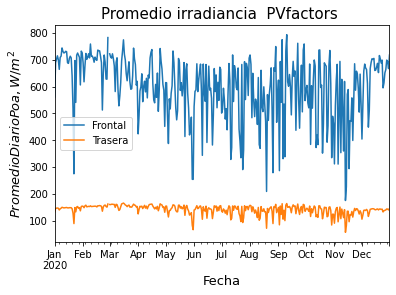

In [59]:

#poa_frontabsorb.plot()
poa_frontabsorb_mean=poa_frontabsorb.resample("1D").mean()
poa_frontabsorb_mean.plot()
poa_backabsorb_mean=poa_backabsorb.resample("1D").mean()
poa_backabsorb_mean.plot()
title='Promedio irradiancia  PVfactors '
ylabel='$Promedio Diario Poa, W/m^2$'
xlabel='Fecha'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(['Frontal','Trasera'])


# Comparación efecto de la posición en el array

In [31]:
poa_front1,poa_back1,poa_frontabsorb1,poa_backabsorb1 = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=0,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=0,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)




c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [32]:

poa_front3,poa_back3,poa_frontabsorb3,poa_backabsorb3 = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=0,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=2,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [33]:
poa_front5,poa_back5,poa_frontabsorb5,poa_backabsorb5 = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=0,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=4,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

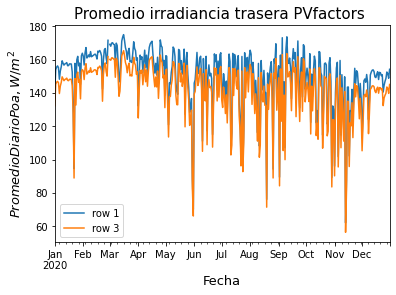

In [34]:
poa_back_mean1=poa_backabsorb1.resample("1D").mean()
poa_back_mean1.plot()
poa_back_mean3=poa_backabsorb3.resample("1D").mean()
poa_back_mean3.plot()
poa_back_mean5=poa_backabsorb5.resample("1D").mean()
#poa_back_mean5.plot()
title='Promedio irradiancia trasera PVfactors '
ylabel='$Promedio Diario Poa, W/m^2$'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['row 1','row 3'])

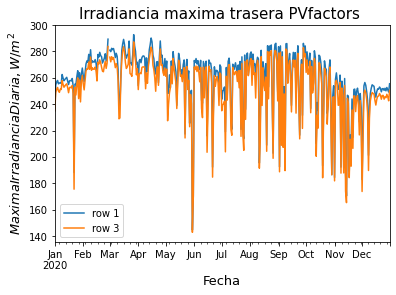

In [35]:
poa_back_max1=poa_backabsorb1.resample("1D").max()
poa_back_max1.plot()
poa_back_max3=poa_backabsorb3.resample("1D").max()
poa_back_max3.plot()
poa_back_max5=poa_backabsorb5.resample("1D").max()
#poa_back_max5.plot()
title='Irradiancia maxima trasera PVfactors '
ylabel='$Maxima Irradiancia Diaria, W/m^2$'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['row 1','row 3'])

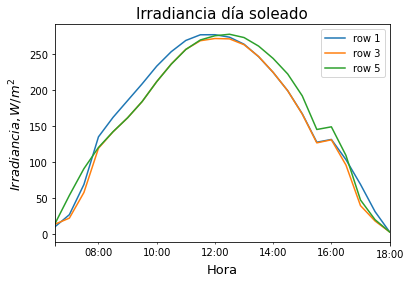

In [36]:
fecha = '2020-02-20 '
poa_1=poa_backabsorb1[fecha+'00:00:00':fecha+'23:59:00']
poa_2=poa_backabsorb3[fecha+'00:00:00':fecha+'23:59:00']
poa_3=poa_backabsorb5[fecha+'00:00:00':fecha+'23:59:00']
poa_1.plot()
poa_2.plot()
poa_3.plot()
title='Irradiancia día soleado'
ylabel='$Irradiancia, W/m^2$'
xlabel='Hora'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['row 1','row 3','row 5'])

# Comparación poa_frontabsorb, poa_front y poa_perez

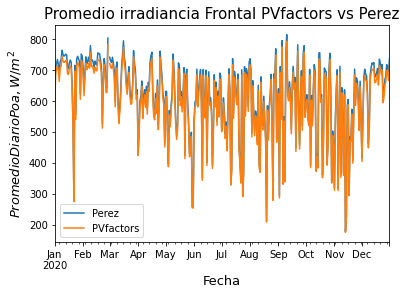

In [37]:
#poa_perez.poa_global.plot()

poa_perez_mean=poa_perez.poa_global.resample("1D").mean()
poa_perez_mean.plot()
poa_frontabsorb_mean.plot()
title='Promedio irradiancia Frontal PVfactors vs Perez'
ylabel='$Promedio Diario Poa, W/m^2$'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['Perez','PVfactors'])

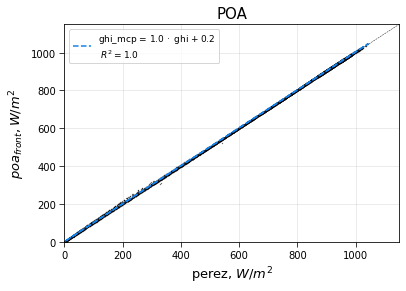

R2:  1.0
RMSE:  0.38
MAPE:  0.35


In [38]:
irrads = pd.DataFrame({'perez': poa_perez['poa_global'], 
                           'poa_front': poa_front})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.perez
y_value = irrads.poa_front

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('ghi_mcp = ' + 
                  f'{slope.round(2)} $· \:$ ghi $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

Funciones.plot_specs(title=f'POA',
            ylabel='$poa_{front}, W/m^2$',
            xlabel='perez, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
Funciones.metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

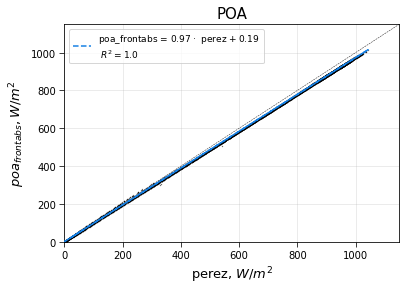

R2:  1.0
RMSE:  1.78
MAPE:  2.83


In [39]:
irrads = pd.DataFrame({'perez': poa_perez['poa_global'], 
                           'poa_frontabsorb': poa_frontabsorb})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.perez
y_value = irrads.poa_frontabsorb

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('poa_frontabs = ' + 
                  f'{slope.round(2)} $· \:$ perez $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

Funciones.plot_specs(title=f'POA',
            ylabel='$poa_{frontabs}, W/m^2$',
            xlabel='perez, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
                        
plt.show()
                        
#METRICS
Funciones.metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

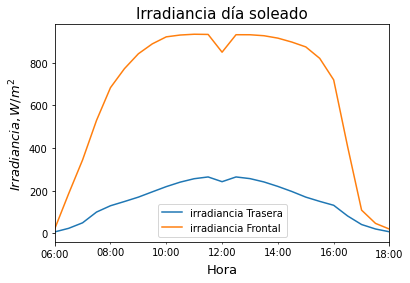

In [76]:
fecha = '2020-07-16 '
poa_1=poa_backabsorb[fecha+'00:00:00':fecha+'23:59:00']
poa_2=poa_frontabsorb[fecha+'00:00:00':fecha+'23:59:00']

poa_1.plot()
poa_2.plot()
title='Irradiancia día soleado'
ylabel='$Irradiancia, W/m^2$'
xlabel='Hora'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['irradiancia Trasera','irradiancia Frontal'])

Text(0.5, 0, 'Fecha')

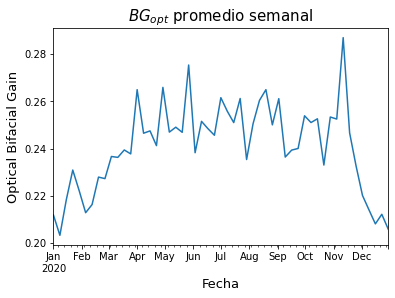

In [79]:
fecha = '2020-11-28 '
fecha2='2020-11-29 '
poa_1=poa_backabsorb
poa_2=poa_frontabsorb
poa_backabsorb_sum=poa_backabsorb.resample("1D").sum()
poa_frontabsorb_sum=poa_frontabsorb.resample("1D").sum()
bg_opt=poa_backabsorb_sum.truediv(poa_frontabsorb_sum)

bg_opt=bg_opt.resample("7D").mean()

bg_opt.plot()
title='$BG_{opt}$ promedio semanal'
ylabel='Optical Bifacial Gain'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)



# Calculo de la producción energetica total

In [42]:
def irrad_total_bifacial(front,back, bifaciality):
    try:
        x=back.mul(bifaciality)
        irrad=front.add(x)
        return(irrad)
    except: 
        print("irrad_total_bifacial failed")

In [43]:
irrad3=irrad_total_bifacial(poa_frontabsorb,
                            poa_backabsorb,0.90)

irrad1=irrad_total_bifacial(poa_frontabsorb1,
                            poa_backabsorb1,0.90)

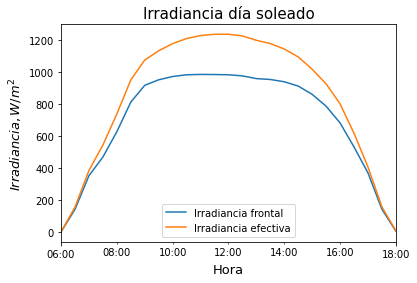

In [44]:
fecha = '2020-03-22 '
poa_1=poa_frontabsorb[fecha+'00:00:00':fecha+'23:59:00']
irrad_1=irrad3[fecha+'00:00:00':fecha+'23:59:00']

poa_1.plot()
irrad_1.plot()
title='Irradiancia día soleado'
ylabel='$Irradiancia, W/m^2$'
xlabel='Hora'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(["Irradiancia frontal","Irradiancia efectiva"])

In [45]:
temp_cell = pvlib.temperature.sapm_module(poa_global=poa_front, 
                                        temp_air=elpaso_tmy.temp_air, 
                                        wind_speed=elpaso_tmy.wind_speed, 
                                        a=-3.47, 
                                        b=-0.0594)


In [46]:
modules_database = 'CECMOD'
modules = pvlib.pvsystem.retrieve_sam(modules_database)

modules.to_csv("DB.csv")
module=modules.LG_Electronics_Inc__LG370N2T_A4
print(module)

Technology            Mono-c-Si
Bifacial                      1
STC                      370.76
PTC                       340.6
A_c                        1.95
Length                     1.99
Width                      0.98
N_s                          72
I_sc_ref                   9.78
V_oc_ref                   48.8
I_mp_ref                    9.2
V_mp_ref                   40.3
alpha_sc               0.002934
beta_oc                -0.13176
T_NOCT                     46.8
a_ref                  1.829992
I_L_ref                9.790371
I_o_ref                     0.0
R_s                    0.311815
R_sh_ref             294.038879
Adjust                 8.790824
gamma_r                   -0.37
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: LG_Electronics_Inc__LG370N2T_A4, dtype: object


In [47]:
inverters_database = 'CECInverter'
inverters = pvlib.pvsystem.retrieve_sam(inverters_database)
inversor = inverters.Power_Electronics__FS1275CU15__690V_
print(inversor)

Vac                          690
Pso                 12941.101563
Paco                   1389080.0
Pdco                   1421523.0
Vdco                      1030.0
C0                          -0.0
C1                      0.000007
C2                     -0.000112
C3                      0.000557
Pnt                      416.724
Vdcmax                    1200.0
Idcmax               1380.119417
Mppt_low                   976.0
Mppt_high                 1200.0
CEC_Date              10/15/2018
CEC_Type     Utility Interactive
Name: Power_Electronics__FS1275CU15__690V_, dtype: object


In [48]:
#String Boxes 7

Pvrow_border=2
mps_A = 40 #Modules Per String
spi_A = 150 #Strings Per Inverter


system_A = pvlib.pvsystem.PVSystem(module_parameters=module, 
                    inverter_parameters=inversor, 
                    modules_per_string=mps_A, 
                    strings_per_inverter=spi_A)


In [49]:
def dc_production(effective_irradiance, module_temperature,module,system):
    #Single Diode Parameters
    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(effective_irradiance,
                                                      module_temperature,
                                                      module['alpha_sc'],
                                                      module['a_ref'],
                                                      module['I_L_ref'],
                                                      module['I_o_ref'],
                                                      module['R_sh_ref'],
                                                      module['R_s'],
                                                      module['Adjust'],
                                                      EgRef=1.121,
                                                      dEgdT=-0.0002677)

    curve_info = pvlib.pvsystem.singlediode(photocurrent=IL,
                                      saturation_current=I0,
                                      resistance_series=Rs,
                                      resistance_shunt=Rsh,
                                      nNsVth=nNsVth,
                                      ivcurve_pnts=100,
                                      method='lambertw')

    #Scalating CEC et. al. Single Diode Results
    data_i_sc = pd.Series(curve_info['i_sc'])
    data_v_oc = pd.Series(curve_info['v_oc'])
    data_i_mp = pd.Series(curve_info['i_mp'])
    data_v_mp = pd.Series(curve_info['v_mp'])
    data_p_mp = pd.Series(curve_info['p_mp'])
    data_i_x = pd.Series(curve_info['i_x'])
    data_i_xx = pd.Series(curve_info['i_xx'])

    results_general = pd.DataFrame({'i_sc': data_i_sc, 
                                    'v_oc': data_v_oc,
                                    'i_mp': data_i_mp, 
                                    'v_mp': data_v_mp, 
                                    'p_mp': data_p_mp, 
                                    'i_x': data_i_x,
                                    'i_xx': data_i_xx})

    #DC Dataframe
    datetime_index = effective_irradiance.index

    dc = system.scale_voltage_current_power(results_general)
    dc = dc.set_index(datetime_index)

    
    return dc

In [50]:
Dc_bi_mid=dc_production(irrad3,temp_cell,module,system_A)
Dc=dc_production(poa_frontabsorb,temp_cell,module,system_A)

In [51]:
def losses(dc, loss):
    losses = loss/100 
    dc['i_mp'] = dc['i_mp'] - dc['i_mp']*losses
    dc['p_mp'] = dc['p_mp'] - dc['p_mp']*losses
    return dc

<AxesSubplot:>

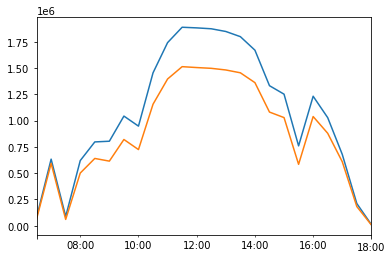

In [52]:
Dc_bi_mid=losses(Dc_bi_mid, 14)

Dc=losses(Dc, 14)

fecha = '2020-02-22 '
Dc_1=Dc_bi_mid[fecha+'00:00:00':fecha+'23:59:00']
Dc_2=Dc[fecha+'00:00:00':fecha+'23:59:00']
Dc_1["p_mp"].plot()
Dc_2["p_mp"].plot()


In [53]:
#PVlib (SAPM) AC Model
def pvlib_ac_power(dc,inverter, total_inversores=1):
    ac= pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    
    
    pvlib_ac = ac * total_inversores
    
    pvlib_ac.loc[pvlib_ac < 0] = 0
    pvlib_ac.fillna(value=0, inplace=True)
    
    return pvlib_ac


In [54]:
ac_bi=pvlib_ac_power(Dc_bi_mid,inversor)
ac=pvlib_ac_power(Dc,inversor)


<AxesSubplot:>

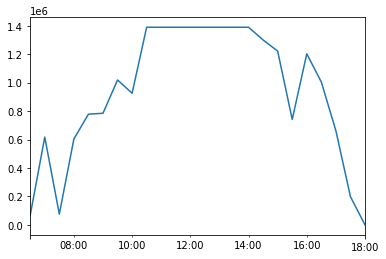

In [55]:
fecha = '2020-02-22 '
fecha2='2020-02-24 '
ac_1=ac_bi[fecha+'00:00:00':fecha+'23:59:00']

ac_2=ac[fecha+'00:00:00':fecha+'23:59:00']
ac_1.plot()
#ac_2.plot()

<AxesSubplot:>

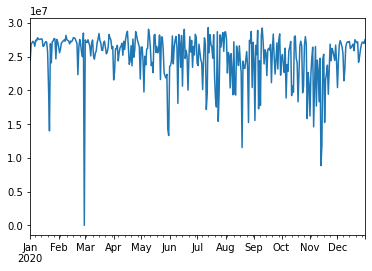

In [56]:
ac_bi_daily=ac_bi.resample("1D").sum()
ac_bi_daily.plot()


In [57]:
Energy_bi=ac_bi.sum()
print(Energy_bi)
Energy_i=ac.sum()
print(Energy_i)

9140795395.700905
8416500438.764308
